### Aerial without any neural network

by Côme Cambien , Martin Vitani , Clément Dilasser

the goal of this project is to get the best possible results without using any neural network

In [1]:
#our libs
import lib.tools as t
import lib.tile_model as tile
import lib.casc_tile_model as casc

load data

In [2]:
#please put the full dataset in the folder
from sys import path;
path.append('ingestion_program/')

data_dir = 'public_data'
data_name = 'Areal'

from ingestion_program.data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)

Reading public_data/Areal_train from AutoML format
Number of examples = 5200
Number of features = 49152
        Class
0       beach
1   chaparral
2       cloud
3      desert
4      forest
5      island
6        lake
7      meadow
8    mountain
9       river
10        sea
11   snowberg
12    wetland
Number of classes = 13


transform data

In [3]:
ys=[data.iloc[i][-1] for i in range(3000)]
xs=[list(data.iloc[i][:-1]) for i in range(3000)]

from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler=StandardScaler()
xss=scaler.fit_transform(xs)

dataset repartition

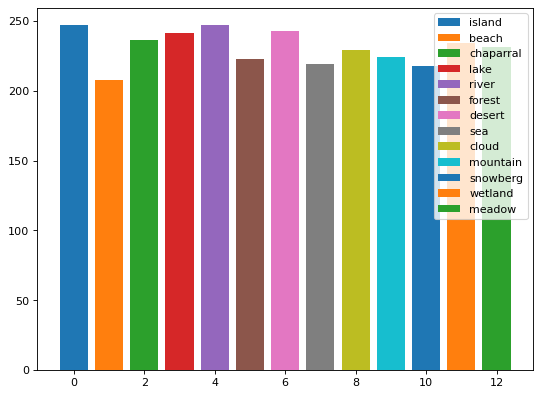

In [4]:
t.repartition(ys)

### naive model (see naive.ipynb)

### tile model

we divide our images in tiles and we train our model on each tile of the train set

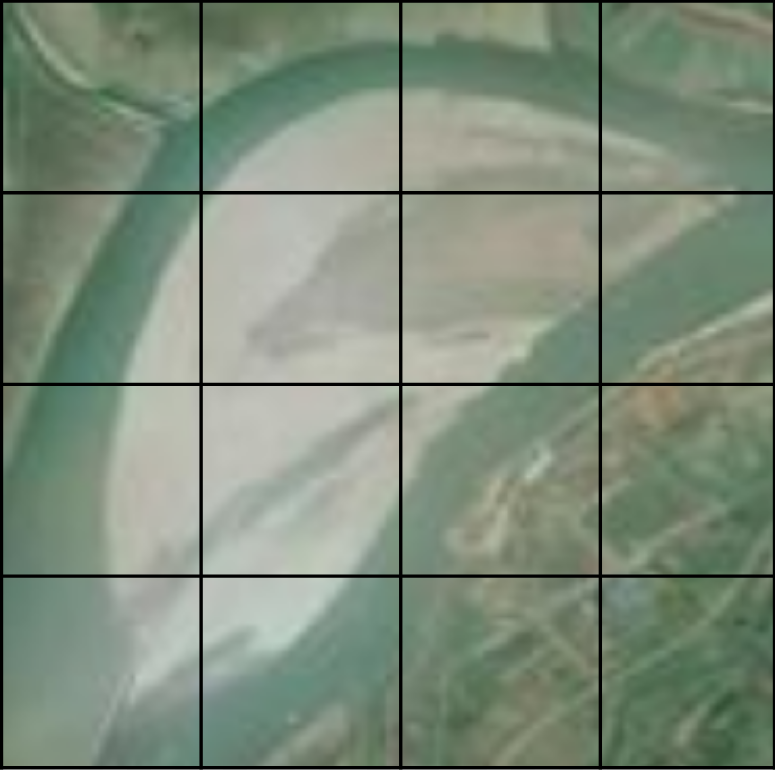

Here we choose to divide the image into subimages of (imsize/8)*(imsize/8) where imsize is the size image

to choose the model we used the library pycaret (see model_search.ipynb)

In [5]:
#we reduce the size of the dataset to be faster and have something executable by our computeurs
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
        xss[:1500],ys[:1500], test_size=0.2)


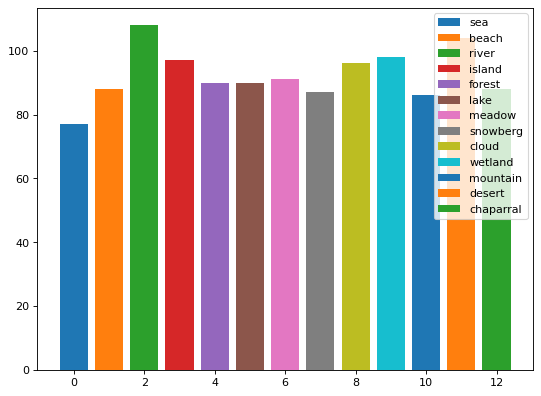

In [6]:
t.repartition(y_train)

In [7]:
from lightgbm import LGBMClassifier

In [8]:
m1=LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=76, min_child_weight=0.001, min_split_gain=0.6,
               n_estimators=220, n_jobs=-1, num_leaves=50, objective=None,
               random_state=415, reg_alpha=0.7, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [9]:
trained_m1,pca=tile.tile_train(m1,x_train,y_train,tile_size=8,offset=8,pca=True,n_cpnt=50)

fiting time
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


we now have a trained model, then to choose the label of an image, we choose the more common label in its subimages

In [10]:
y_pred=tile.tile_test(trained_m1,x_test,tile_size=8,offset=8,pc=True,pca=pca)

In [11]:
t.score(y_pred,y_test)

0.71

now we can look at the rate of good prediction per class

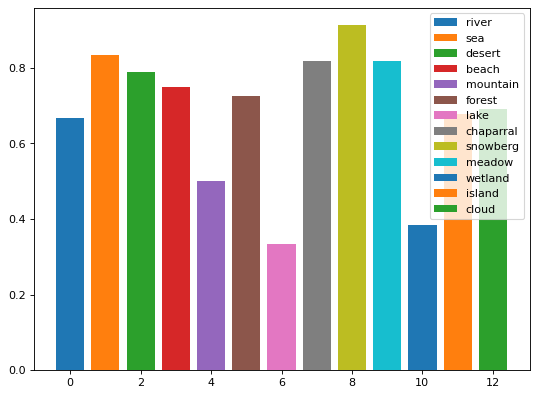

In [12]:
t.true_pred(y_pred,y_test)

### tile cascade model

this model is on top of the tile model : this time when we have predicted the label of the subimages for each possible class we store the percentage of prediction (number of subimages predicted as class A /number of subimages)then we use an other model to predict the actual label of the image

we need to divide our train set into two set : one for each model

In [13]:
#we reduce the size of the dataset to be faster and have something executable by our computeurs
x_train, x_test, y_train, y_test = train_test_split(
        xss[:3000], ys[:3000], test_size=0.2)
x_train1, x_train2, y_train1, y_train2 = train_test_split(
        x_train, y_train, test_size=0.5)

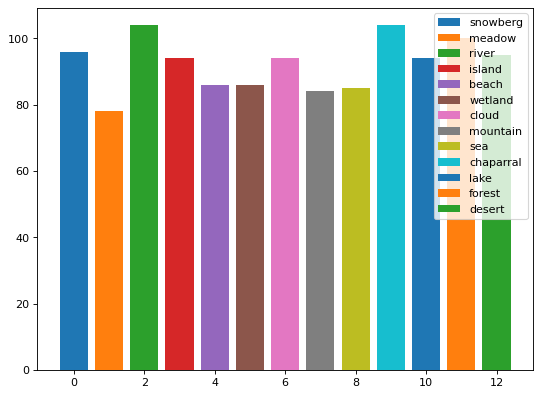

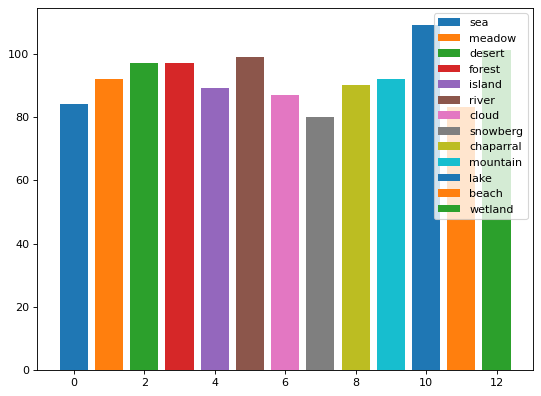

In [14]:
t.repartition(y_train1)
t.repartition(y_train2)

In [15]:
m2=LGBMClassifier(bagging_fraction=0.5, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=1, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=130, n_jobs=-1, num_leaves=90, objective=None,
               random_state=4245, reg_alpha=1, reg_lambda=0.1, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
#training of the first model
trained_m1,pca=tile.tile_train(m1,x_train1,y_train1,tile_size=8,offset=8,pca=True,n_cpnt=50)

fiting time
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [17]:
#training of the second model
trained_m2=casc.tile_train_c(trained_m1,m2,x_train2,y_train2,tile_size=8,offset=8,pc=True,pca=pca)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [18]:
y_pred2=casc.tile_test_c(trained_m1,trained_m2,x_test,tile_size=8,offset=8,pc=True,pca=pca)

In [19]:
t.score(y_pred2,y_test)

0.7866666666666666

now we can look at the rate of good prediction per class

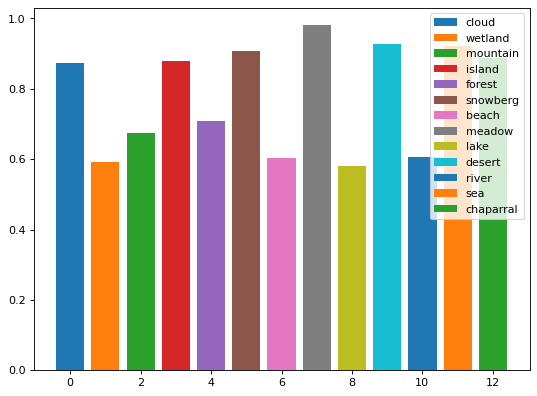

In [20]:
t.true_pred(y_pred2,y_test)

due to the lack of time and computing power we didn't used a Kfold to validate our model but it will be the next thing to to

In [21]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [22]:
#our libs
import lib.tools as t
import lib.tile_model as tile
import lib.casc_tile_model as casc

In [23]:
#please put the full dataset in the folder
from sys import path;
path.append('ingestion_program/')

data_dir = 'public_data'
data_name = 'Areal'

from ingestion_program.data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)

Reading public_data/Areal_train from AutoML format
Number of examples = 5200
Number of features = 49152
        Class
0       beach
1   chaparral
2       cloud
3      desert
4      forest
5      island
6        lake
7      meadow
8    mountain
9       river
10        sea
11   snowberg
12    wetland
Number of classes = 13


In [24]:
ys=[data.iloc[i][-1] for i in range(3000,5000)]
xs=[list(data.iloc[i][:-1]) for i in range(3000,5000)]

from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler=StandardScaler()
xss=scaler.fit_transform(xs)

In [25]:
from lightgbm import LGBMClassifier
m1=LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=76, min_child_weight=0.001, min_split_gain=0.6,
               n_estimators=220, n_jobs=-1, num_leaves=50, objective=None,
               random_state=415, reg_alpha=0.7, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

m2=LGBMClassifier(bagging_fraction=0.5, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=1, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=130, n_jobs=-1, num_leaves=90, objective=None,
               random_state=4245, reg_alpha=1, reg_lambda=0.1, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [27]:
t.kfold(xs,ys,10,lambda xtr,ytr,xte:casc.train_test_c(xtr,ytr,xte,m1,m2))

fold 1/10
fiting time
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
fold 2/10
fiting time
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warni

0.8035